In [1]:
import torch
import torch.nn as nn
from torch import optim
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from easyfsl.samplers import TaskSampler
from easyfsl.utils import plot_images
from easyfsl.utils import sliding_average
from easyfsl.utils import evaluate
from easyfsl.datasets import WrapFewShotDataset
from torchvision.models import resnet18
from tqdm import tqdm

In [2]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to fit ResNet-18 input size
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
])

dataset = ImageFolder(
    root='data2',
    transform=transform
)

In [3]:
train_dataset, test_dataset = train_test_split(dataset, test_size=0.2)

c:\Users\Glen\AppData\Local\Programs\Python\Python312\Lib\site-packages\PIL\Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [4]:
len(train_dataset), len(test_dataset)

(752, 188)

In [5]:
class PrototypicalNetwork(nn.Module):
    def __init__(self, encoding_function):
        super(PrototypicalNetwork, self).__init__()
        self.encoding_function = encoding_function
        
    def forward(self, support_data, support_labels, query_data):
        # Getting embeddings for support and query set by forward propagating through pre-trained RestNet model
        support_data_ = self.encoding_function.forward(support_data)
        query_data_ = self.encoding_function.forward(query_data)
        
        
        # No. of classes
        n_way = len(torch.unique(support_labels))
        
        # Computing class prototypes (mean of all instances to their corresponding label)
        class_prototypes = torch.cat(
            [
                support_data_[torch.nonzero(support_labels == label)].mean(0)
                for label in range(n_way)
            ]
        )
        
        # one_hot_labels = nn.functional.one_hot(support_labels, num_classes=n_way)
        
        # indices = torch.nonzero(one_hot_labels, as_tuple=True)
        
        # # Initialize tensor to hold the prototypes
        # class_prototypes = torch.zeros(n_way, support_data_.size(1))

        # for i in range(n_way):
        #     # Embeddings of the current class
        #     class_embeddings = support_data_[one_hot_labels[indices] == i]
        #     # Compute the mean of the embeddings to get the prototype
        #     class_prototypes[i] = class_embeddings.mean(dim=0)
            
        # Computing the euclidian distance between queries and class prototypes
        distances = torch.cdist(query_data_, class_prototypes)
        
        # Using softmax to transform distances to classification scores
        logits = -distances
        # classification_scores = logits.softmax(dim=1)
        
        return logits
    
encoding_function = resnet18(pretrained=True)
encoding_function.fc = nn.Flatten()

few_shot_classifier = PrototypicalNetwork(encoding_function)

c:\Users\Glen\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Glen\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [6]:
N_WAY = 2  # Number of classes in a task
N_SHOT = 4  # Number of images per class in the support set
N_QUERY = 8  # Number of images per class in the query set

N_EVALUATION_TASKS = 100
N_TRAINING_EPISODES = 400
N_VALIDATION_TASKS = 100

test_dataset_ = WrapFewShotDataset(test_dataset)

test_dataset_.get_labels = lambda: [
    instance[1] for instance in test_dataset
]

test_sampler = TaskSampler(
    test_dataset_, n_way=N_WAY, n_shot=N_SHOT, n_query=N_QUERY, n_tasks=N_EVALUATION_TASKS
)

test_loader = DataLoader(
    test_dataset_,
    batch_sampler=test_sampler,
    num_workers=0,
    pin_memory=True,
    collate_fn=test_sampler.episodic_collate_fn,
)

train_dataset_ = WrapFewShotDataset(train_dataset)

train_dataset_.get_labels = lambda: [instance[1] for instance in test_dataset]

train_sampler = TaskSampler(
    train_dataset_, n_way=N_WAY, n_shot=N_SHOT, n_query=N_QUERY, n_tasks=N_TRAINING_EPISODES
)

train_loader = DataLoader(
    train_dataset_,
    batch_sampler=train_sampler,
    num_workers=0,
    pin_memory=True,
    collate_fn=train_sampler.episodic_collate_fn,
)

Scrolling dataset's labels...: 100%|██████████| 752/752 [00:00<00:00, 745301.66it/s]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1007793..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


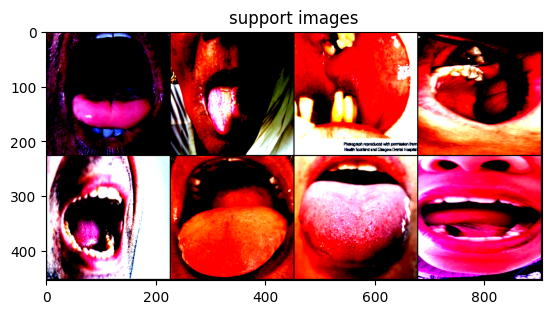

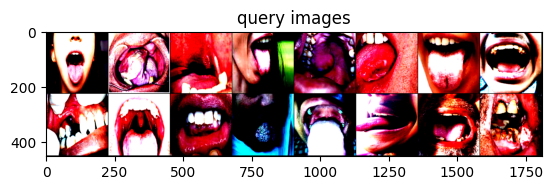

In [7]:
(
    example_support_images,
    example_support_labels,
    example_query_images,
    example_query_labels,
    example_class_ids,
) = next(iter(train_loader))

plot_images(example_support_images, "support images", images_per_row=N_SHOT)
plot_images(example_query_images, "query images", images_per_row=N_QUERY)

In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(few_shot_classifier.parameters(), lr=0.001)

def fit(
    support_images: torch.Tensor,
    support_labels: torch.Tensor,
    query_images: torch.Tensor,
    query_labels: torch.Tensor,
) -> float:
    optimizer.zero_grad()
    classification_scores = few_shot_classifier(
        support_images, support_labels, query_images
    )

    print(classification_scores.shape, query_labels.shape)
    loss = criterion(classification_scores, query_labels)
    loss.backward()
    optimizer.step()

    return loss.item()

In [9]:
# Train the model yourself with this cell

log_update_frequency = 5

all_loss = []
few_shot_classifier.train()
with tqdm(enumerate(train_loader), total=len(train_loader)) as tqdm_train:
    for episode_index, (
        support_images,
        support_labels,
        query_images,
        query_labels,
        _,
    ) in tqdm_train:
        loss_value = fit(support_images, support_labels, query_images, query_labels)
        all_loss.append(loss_value)

        if episode_index % log_update_frequency == 0:
            tqdm_train.set_postfix(loss=sliding_average(all_loss, log_update_frequency))

  0%|          | 0/200 [00:00<?, ?it/s]

torch.Size([16, 2]) torch.Size([16])


  0%|          | 1/200 [00:01<04:07,  1.24s/it, loss=0.553]

torch.Size([16, 2]) torch.Size([16])


  1%|          | 2/200 [00:02<03:50,  1.16s/it, loss=0.553]

torch.Size([16, 2]) torch.Size([16])


  2%|▏         | 3/200 [00:03<03:41,  1.12s/it, loss=0.553]

torch.Size([16, 2]) torch.Size([16])


  2%|▏         | 4/200 [00:04<03:37,  1.11s/it, loss=0.553]

torch.Size([16, 2]) torch.Size([16])


  2%|▎         | 5/200 [00:05<03:34,  1.10s/it, loss=0.553]

torch.Size([16, 2]) torch.Size([16])


  3%|▎         | 6/200 [00:06<03:34,  1.11s/it, loss=0.703]

torch.Size([16, 2]) torch.Size([16])


  4%|▎         | 7/200 [00:07<03:38,  1.13s/it, loss=0.703]

torch.Size([16, 2]) torch.Size([16])


  4%|▍         | 8/200 [00:08<03:33,  1.11s/it, loss=0.703]

torch.Size([16, 2]) torch.Size([16])


  4%|▍         | 9/200 [00:10<03:29,  1.10s/it, loss=0.703]

torch.Size([16, 2]) torch.Size([16])


  5%|▌         | 10/200 [00:11<03:27,  1.09s/it, loss=0.703]

torch.Size([16, 2]) torch.Size([16])


  6%|▌         | 11/200 [00:12<03:25,  1.09s/it, loss=0.612]

torch.Size([16, 2]) torch.Size([16])


  6%|▌         | 12/200 [00:13<03:24,  1.09s/it, loss=0.612]

torch.Size([16, 2]) torch.Size([16])


  6%|▋         | 13/200 [00:14<03:23,  1.09s/it, loss=0.612]

torch.Size([16, 2]) torch.Size([16])


  7%|▋         | 14/200 [00:15<03:24,  1.10s/it, loss=0.612]

torch.Size([16, 2]) torch.Size([16])


  8%|▊         | 15/200 [00:16<03:30,  1.14s/it, loss=0.612]

torch.Size([16, 2]) torch.Size([16])


  8%|▊         | 16/200 [00:17<03:30,  1.14s/it, loss=0.987]

torch.Size([16, 2]) torch.Size([16])


  8%|▊         | 17/200 [00:19<03:28,  1.14s/it, loss=0.987]

torch.Size([16, 2]) torch.Size([16])


  9%|▉         | 18/200 [00:20<03:24,  1.13s/it, loss=0.987]

torch.Size([16, 2]) torch.Size([16])


 10%|▉         | 19/200 [00:21<03:23,  1.12s/it, loss=0.987]

torch.Size([16, 2]) torch.Size([16])


 10%|█         | 20/200 [00:22<03:19,  1.11s/it, loss=0.987]

torch.Size([16, 2]) torch.Size([16])


 10%|█         | 21/200 [00:23<03:16,  1.10s/it, loss=0.453]

torch.Size([16, 2]) torch.Size([16])


 11%|█         | 22/200 [00:24<03:15,  1.10s/it, loss=0.453]

torch.Size([16, 2]) torch.Size([16])


 12%|█▏        | 23/200 [00:25<03:13,  1.10s/it, loss=0.453]

torch.Size([16, 2]) torch.Size([16])


 12%|█▏        | 24/200 [00:26<03:16,  1.12s/it, loss=0.453]

torch.Size([16, 2]) torch.Size([16])


 12%|█▎        | 25/200 [00:27<03:14,  1.11s/it, loss=0.453]

torch.Size([16, 2]) torch.Size([16])


 13%|█▎        | 26/200 [00:28<03:12,  1.11s/it, loss=1.89] 

torch.Size([16, 2]) torch.Size([16])


 14%|█▎        | 27/200 [00:30<03:11,  1.11s/it, loss=1.89]

torch.Size([16, 2]) torch.Size([16])


 14%|█▍        | 28/200 [00:31<03:09,  1.10s/it, loss=1.89]

torch.Size([16, 2]) torch.Size([16])


 14%|█▍        | 29/200 [00:32<03:12,  1.12s/it, loss=1.89]

torch.Size([16, 2]) torch.Size([16])


 15%|█▌        | 30/200 [00:33<03:13,  1.14s/it, loss=1.89]

torch.Size([16, 2]) torch.Size([16])


 16%|█▌        | 31/200 [00:34<03:09,  1.12s/it, loss=2.17]

torch.Size([16, 2]) torch.Size([16])


 16%|█▌        | 32/200 [00:35<03:06,  1.11s/it, loss=2.17]

torch.Size([16, 2]) torch.Size([16])


 16%|█▋        | 33/200 [00:36<03:08,  1.13s/it, loss=2.17]

torch.Size([16, 2]) torch.Size([16])


 17%|█▋        | 34/200 [00:37<03:04,  1.11s/it, loss=2.17]

torch.Size([16, 2]) torch.Size([16])


 18%|█▊        | 35/200 [00:38<03:01,  1.10s/it, loss=2.17]

torch.Size([16, 2]) torch.Size([16])


 18%|█▊        | 36/200 [00:40<03:00,  1.10s/it, loss=2.15]

torch.Size([16, 2]) torch.Size([16])


 18%|█▊        | 37/200 [00:41<02:59,  1.10s/it, loss=2.15]

torch.Size([16, 2]) torch.Size([16])


 19%|█▉        | 38/200 [00:42<02:58,  1.10s/it, loss=2.15]

torch.Size([16, 2]) torch.Size([16])


 20%|█▉        | 39/200 [00:43<02:56,  1.10s/it, loss=2.15]

torch.Size([16, 2]) torch.Size([16])


 20%|██        | 40/200 [00:44<03:00,  1.13s/it, loss=2.15]

torch.Size([16, 2]) torch.Size([16])


 20%|██        | 41/200 [00:45<02:56,  1.11s/it, loss=1.99]

torch.Size([16, 2]) torch.Size([16])


 21%|██        | 42/200 [00:46<02:54,  1.11s/it, loss=1.99]

torch.Size([16, 2]) torch.Size([16])


 22%|██▏       | 43/200 [00:47<02:52,  1.10s/it, loss=1.99]

torch.Size([16, 2]) torch.Size([16])


 22%|██▏       | 44/200 [00:48<02:51,  1.10s/it, loss=1.99]

torch.Size([16, 2]) torch.Size([16])


 22%|██▎       | 45/200 [00:50<02:50,  1.10s/it, loss=1.99]

torch.Size([16, 2]) torch.Size([16])


 23%|██▎       | 46/200 [00:51<02:49,  1.10s/it, loss=1.89]

torch.Size([16, 2]) torch.Size([16])


 24%|██▎       | 47/200 [00:52<02:48,  1.10s/it, loss=1.89]

torch.Size([16, 2]) torch.Size([16])


 24%|██▍       | 48/200 [00:53<02:47,  1.10s/it, loss=1.89]

torch.Size([16, 2]) torch.Size([16])


 24%|██▍       | 49/200 [00:54<02:45,  1.10s/it, loss=1.89]

torch.Size([16, 2]) torch.Size([16])


 25%|██▌       | 50/200 [00:55<02:44,  1.10s/it, loss=1.89]

torch.Size([16, 2]) torch.Size([16])


 26%|██▌       | 51/200 [00:56<02:43,  1.10s/it, loss=1.16]

torch.Size([16, 2]) torch.Size([16])


 26%|██▌       | 52/200 [00:57<02:47,  1.13s/it, loss=1.16]

torch.Size([16, 2]) torch.Size([16])


 26%|██▋       | 53/200 [00:58<02:45,  1.13s/it, loss=1.16]

torch.Size([16, 2]) torch.Size([16])


 27%|██▋       | 54/200 [00:59<02:42,  1.11s/it, loss=1.16]

torch.Size([16, 2]) torch.Size([16])


 28%|██▊       | 55/200 [01:01<02:40,  1.11s/it, loss=1.16]

torch.Size([16, 2]) torch.Size([16])


 28%|██▊       | 56/200 [01:02<02:39,  1.11s/it, loss=0.955]

torch.Size([16, 2]) torch.Size([16])


 28%|██▊       | 57/200 [01:03<02:39,  1.11s/it, loss=0.955]

torch.Size([16, 2]) torch.Size([16])


 29%|██▉       | 58/200 [01:04<02:36,  1.11s/it, loss=0.955]

torch.Size([16, 2]) torch.Size([16])


 30%|██▉       | 59/200 [01:05<02:34,  1.10s/it, loss=0.955]

torch.Size([16, 2]) torch.Size([16])


 30%|███       | 60/200 [01:06<02:34,  1.10s/it, loss=0.955]

torch.Size([16, 2]) torch.Size([16])


 30%|███       | 61/200 [01:07<02:32,  1.10s/it, loss=0.611]

torch.Size([16, 2]) torch.Size([16])


 31%|███       | 62/200 [01:08<02:29,  1.09s/it, loss=0.611]

torch.Size([16, 2]) torch.Size([16])


 32%|███▏      | 63/200 [01:09<02:33,  1.12s/it, loss=0.611]

torch.Size([16, 2]) torch.Size([16])


 32%|███▏      | 64/200 [01:11<02:32,  1.12s/it, loss=0.611]

torch.Size([16, 2]) torch.Size([16])


 32%|███▎      | 65/200 [01:12<02:29,  1.11s/it, loss=0.611]

torch.Size([16, 2]) torch.Size([16])


 33%|███▎      | 66/200 [01:13<02:28,  1.11s/it, loss=0.631]

torch.Size([16, 2]) torch.Size([16])


 34%|███▎      | 67/200 [01:14<02:26,  1.11s/it, loss=0.631]

torch.Size([16, 2]) torch.Size([16])


 34%|███▍      | 68/200 [01:15<02:25,  1.10s/it, loss=0.631]

torch.Size([16, 2]) torch.Size([16])


 34%|███▍      | 69/200 [01:16<02:24,  1.10s/it, loss=0.631]

torch.Size([16, 2]) torch.Size([16])


 35%|███▌      | 70/200 [01:17<02:22,  1.10s/it, loss=0.631]

torch.Size([16, 2]) torch.Size([16])


 36%|███▌      | 71/200 [01:18<02:20,  1.09s/it, loss=0.731]

torch.Size([16, 2]) torch.Size([16])


 36%|███▌      | 72/200 [01:19<02:23,  1.12s/it, loss=0.731]

torch.Size([16, 2]) torch.Size([16])


 36%|███▋      | 73/200 [01:21<02:22,  1.12s/it, loss=0.731]

torch.Size([16, 2]) torch.Size([16])


 37%|███▋      | 74/200 [01:22<02:21,  1.12s/it, loss=0.731]

torch.Size([16, 2]) torch.Size([16])


 38%|███▊      | 75/200 [01:23<02:19,  1.12s/it, loss=0.731]

torch.Size([16, 2]) torch.Size([16])


 38%|███▊      | 76/200 [01:24<02:18,  1.11s/it, loss=0.807]

torch.Size([16, 2]) torch.Size([16])


 38%|███▊      | 77/200 [01:25<02:16,  1.11s/it, loss=0.807]

torch.Size([16, 2]) torch.Size([16])


 39%|███▉      | 78/200 [01:26<02:16,  1.12s/it, loss=0.807]

torch.Size([16, 2]) torch.Size([16])


 40%|███▉      | 79/200 [01:27<02:14,  1.11s/it, loss=0.807]

torch.Size([16, 2]) torch.Size([16])


 40%|████      | 80/200 [01:28<02:14,  1.12s/it, loss=0.807]

torch.Size([16, 2]) torch.Size([16])


 40%|████      | 81/200 [01:29<02:13,  1.12s/it, loss=0.861]

torch.Size([16, 2]) torch.Size([16])


 41%|████      | 82/200 [01:31<02:15,  1.15s/it, loss=0.861]

torch.Size([16, 2]) torch.Size([16])


 42%|████▏     | 83/200 [01:32<02:12,  1.13s/it, loss=0.861]

torch.Size([16, 2]) torch.Size([16])


 42%|████▏     | 84/200 [01:33<02:09,  1.11s/it, loss=0.861]

torch.Size([16, 2]) torch.Size([16])


 42%|████▎     | 85/200 [01:34<02:06,  1.10s/it, loss=0.861]

torch.Size([16, 2]) torch.Size([16])


 43%|████▎     | 86/200 [01:35<02:04,  1.09s/it, loss=1.08] 

torch.Size([16, 2]) torch.Size([16])


 44%|████▎     | 87/200 [01:36<02:03,  1.09s/it, loss=1.08]

torch.Size([16, 2]) torch.Size([16])


 44%|████▍     | 88/200 [01:37<02:01,  1.09s/it, loss=1.08]

torch.Size([16, 2]) torch.Size([16])


 44%|████▍     | 89/200 [01:38<02:00,  1.09s/it, loss=1.08]

torch.Size([16, 2]) torch.Size([16])


 45%|████▌     | 90/200 [01:39<02:03,  1.12s/it, loss=1.08]

torch.Size([16, 2]) torch.Size([16])


 46%|████▌     | 91/200 [01:41<02:02,  1.12s/it, loss=0.577]

torch.Size([16, 2]) torch.Size([16])


 46%|████▌     | 92/200 [01:42<02:02,  1.14s/it, loss=0.577]

torch.Size([16, 2]) torch.Size([16])


 46%|████▋     | 93/200 [01:43<02:01,  1.13s/it, loss=0.577]

torch.Size([16, 2]) torch.Size([16])


 47%|████▋     | 94/200 [01:44<01:59,  1.13s/it, loss=0.577]

torch.Size([16, 2]) torch.Size([16])


 48%|████▊     | 95/200 [01:45<01:56,  1.11s/it, loss=0.577]

torch.Size([16, 2]) torch.Size([16])


 48%|████▊     | 96/200 [01:46<01:54,  1.10s/it, loss=0.738]

torch.Size([16, 2]) torch.Size([16])


 48%|████▊     | 97/200 [01:47<01:52,  1.10s/it, loss=0.738]

torch.Size([16, 2]) torch.Size([16])


 49%|████▉     | 98/200 [01:48<01:51,  1.10s/it, loss=0.738]

torch.Size([16, 2]) torch.Size([16])


 50%|████▉     | 99/200 [01:49<01:51,  1.10s/it, loss=0.738]

torch.Size([16, 2]) torch.Size([16])


 50%|█████     | 100/200 [01:51<01:50,  1.11s/it, loss=0.738]

torch.Size([16, 2]) torch.Size([16])


 50%|█████     | 101/200 [01:52<01:53,  1.15s/it, loss=0.577]

torch.Size([16, 2]) torch.Size([16])


 51%|█████     | 102/200 [01:53<01:52,  1.14s/it, loss=0.577]

torch.Size([16, 2]) torch.Size([16])


 52%|█████▏    | 103/200 [01:54<01:50,  1.14s/it, loss=0.577]

torch.Size([16, 2]) torch.Size([16])


 52%|█████▏    | 104/200 [01:55<01:50,  1.15s/it, loss=0.577]

torch.Size([16, 2]) torch.Size([16])


 52%|█████▎    | 105/200 [01:56<01:49,  1.15s/it, loss=0.577]

torch.Size([16, 2]) torch.Size([16])


 53%|█████▎    | 106/200 [01:58<01:48,  1.15s/it, loss=0.647]

torch.Size([16, 2]) torch.Size([16])


 54%|█████▎    | 107/200 [01:59<01:49,  1.18s/it, loss=0.647]

torch.Size([16, 2]) torch.Size([16])


 54%|█████▍    | 108/200 [02:00<01:46,  1.16s/it, loss=0.647]

torch.Size([16, 2]) torch.Size([16])


 55%|█████▍    | 109/200 [02:01<01:46,  1.17s/it, loss=0.647]

torch.Size([16, 2]) torch.Size([16])


 55%|█████▌    | 110/200 [02:02<01:44,  1.16s/it, loss=0.647]

torch.Size([16, 2]) torch.Size([16])


 56%|█████▌    | 111/200 [02:03<01:42,  1.15s/it, loss=0.777]

torch.Size([16, 2]) torch.Size([16])


 56%|█████▌    | 112/200 [02:04<01:40,  1.14s/it, loss=0.777]

torch.Size([16, 2]) torch.Size([16])


 56%|█████▋    | 113/200 [02:06<01:38,  1.13s/it, loss=0.777]

torch.Size([16, 2]) torch.Size([16])


 57%|█████▋    | 114/200 [02:07<01:36,  1.13s/it, loss=0.777]

torch.Size([16, 2]) torch.Size([16])


 57%|█████▊    | 115/200 [02:08<01:35,  1.12s/it, loss=0.777]

torch.Size([16, 2]) torch.Size([16])


 58%|█████▊    | 116/200 [02:09<01:33,  1.11s/it, loss=0.49] 

torch.Size([16, 2]) torch.Size([16])


 58%|█████▊    | 117/200 [02:10<01:31,  1.10s/it, loss=0.49]

torch.Size([16, 2]) torch.Size([16])


 59%|█████▉    | 118/200 [02:11<01:30,  1.11s/it, loss=0.49]

torch.Size([16, 2]) torch.Size([16])


 60%|█████▉    | 119/200 [02:12<01:29,  1.10s/it, loss=0.49]

torch.Size([16, 2]) torch.Size([16])


 60%|██████    | 120/200 [02:13<01:28,  1.11s/it, loss=0.49]

torch.Size([16, 2]) torch.Size([16])


 60%|██████    | 121/200 [02:14<01:29,  1.14s/it, loss=0.841]

torch.Size([16, 2]) torch.Size([16])


 61%|██████    | 122/200 [02:16<01:27,  1.12s/it, loss=0.841]

torch.Size([16, 2]) torch.Size([16])


 62%|██████▏   | 123/200 [02:17<01:26,  1.12s/it, loss=0.841]

torch.Size([16, 2]) torch.Size([16])


 62%|██████▏   | 124/200 [02:18<01:25,  1.12s/it, loss=0.841]

torch.Size([16, 2]) torch.Size([16])


 62%|██████▎   | 125/200 [02:19<01:23,  1.12s/it, loss=0.841]

torch.Size([16, 2]) torch.Size([16])


 63%|██████▎   | 126/200 [02:20<01:22,  1.12s/it, loss=0.834]

torch.Size([16, 2]) torch.Size([16])


 64%|██████▎   | 127/200 [02:21<01:20,  1.11s/it, loss=0.834]

torch.Size([16, 2]) torch.Size([16])


 64%|██████▍   | 128/200 [02:22<01:19,  1.10s/it, loss=0.834]

torch.Size([16, 2]) torch.Size([16])


 64%|██████▍   | 129/200 [02:23<01:18,  1.11s/it, loss=0.834]

torch.Size([16, 2]) torch.Size([16])


 65%|██████▌   | 130/200 [02:24<01:17,  1.11s/it, loss=0.834]

torch.Size([16, 2]) torch.Size([16])


 66%|██████▌   | 131/200 [02:26<01:18,  1.14s/it, loss=0.873]

torch.Size([16, 2]) torch.Size([16])


 66%|██████▌   | 132/200 [02:27<01:16,  1.12s/it, loss=0.873]

torch.Size([16, 2]) torch.Size([16])


 66%|██████▋   | 133/200 [02:28<01:14,  1.12s/it, loss=0.873]

torch.Size([16, 2]) torch.Size([16])


 67%|██████▋   | 134/200 [02:29<01:13,  1.12s/it, loss=0.873]

torch.Size([16, 2]) torch.Size([16])


 68%|██████▊   | 135/200 [02:30<01:12,  1.12s/it, loss=0.873]

torch.Size([16, 2]) torch.Size([16])


 68%|██████▊   | 136/200 [02:31<01:11,  1.12s/it, loss=0.697]

torch.Size([16, 2]) torch.Size([16])


 68%|██████▊   | 137/200 [02:32<01:10,  1.12s/it, loss=0.697]

torch.Size([16, 2]) torch.Size([16])


 69%|██████▉   | 138/200 [02:33<01:09,  1.12s/it, loss=0.697]

torch.Size([16, 2]) torch.Size([16])


 70%|██████▉   | 139/200 [02:35<01:08,  1.12s/it, loss=0.697]

torch.Size([16, 2]) torch.Size([16])


 70%|███████   | 140/200 [02:36<01:06,  1.11s/it, loss=0.697]

torch.Size([16, 2]) torch.Size([16])


 70%|███████   | 141/200 [02:37<01:05,  1.11s/it, loss=0.741]

torch.Size([16, 2]) torch.Size([16])


 71%|███████   | 142/200 [02:38<01:05,  1.13s/it, loss=0.741]

torch.Size([16, 2]) torch.Size([16])


 72%|███████▏  | 143/200 [02:39<01:04,  1.13s/it, loss=0.741]

torch.Size([16, 2]) torch.Size([16])


 72%|███████▏  | 144/200 [02:40<01:02,  1.12s/it, loss=0.741]

torch.Size([16, 2]) torch.Size([16])


 72%|███████▎  | 145/200 [02:41<01:00,  1.11s/it, loss=0.741]

torch.Size([16, 2]) torch.Size([16])


 73%|███████▎  | 146/200 [02:42<00:59,  1.10s/it, loss=1.12] 

torch.Size([16, 2]) torch.Size([16])


 74%|███████▎  | 147/200 [02:43<00:58,  1.10s/it, loss=1.12]

torch.Size([16, 2]) torch.Size([16])


 74%|███████▍  | 148/200 [02:45<00:57,  1.10s/it, loss=1.12]

torch.Size([16, 2]) torch.Size([16])


 74%|███████▍  | 149/200 [02:46<00:56,  1.11s/it, loss=1.12]

torch.Size([16, 2]) torch.Size([16])


 75%|███████▌  | 150/200 [02:47<00:55,  1.10s/it, loss=1.12]

torch.Size([16, 2]) torch.Size([16])


 76%|███████▌  | 151/200 [02:48<00:54,  1.10s/it, loss=0.948]

torch.Size([16, 2]) torch.Size([16])


 76%|███████▌  | 152/200 [02:49<00:54,  1.13s/it, loss=0.948]

torch.Size([16, 2]) torch.Size([16])


 76%|███████▋  | 153/200 [02:50<00:52,  1.12s/it, loss=0.948]

torch.Size([16, 2]) torch.Size([16])


 77%|███████▋  | 154/200 [02:51<00:50,  1.10s/it, loss=0.948]

torch.Size([16, 2]) torch.Size([16])


 78%|███████▊  | 155/200 [02:52<00:49,  1.11s/it, loss=0.948]

torch.Size([16, 2]) torch.Size([16])


 78%|███████▊  | 156/200 [02:53<00:48,  1.11s/it, loss=0.924]

torch.Size([16, 2]) torch.Size([16])


 78%|███████▊  | 157/200 [02:55<00:48,  1.12s/it, loss=0.924]

torch.Size([16, 2]) torch.Size([16])


 79%|███████▉  | 158/200 [02:56<00:46,  1.11s/it, loss=0.924]

torch.Size([16, 2]) torch.Size([16])


 80%|███████▉  | 159/200 [02:57<00:45,  1.11s/it, loss=0.924]

torch.Size([16, 2]) torch.Size([16])


 80%|████████  | 160/200 [02:58<00:44,  1.11s/it, loss=0.924]

torch.Size([16, 2]) torch.Size([16])


 80%|████████  | 161/200 [02:59<00:43,  1.11s/it, loss=0.632]

torch.Size([16, 2]) torch.Size([16])


 81%|████████  | 162/200 [03:00<00:42,  1.11s/it, loss=0.632]

torch.Size([16, 2]) torch.Size([16])


 82%|████████▏ | 163/200 [03:01<00:41,  1.13s/it, loss=0.632]

torch.Size([16, 2]) torch.Size([16])


 82%|████████▏ | 164/200 [03:02<00:40,  1.13s/it, loss=0.632]

torch.Size([16, 2]) torch.Size([16])


 82%|████████▎ | 165/200 [03:04<00:39,  1.13s/it, loss=0.632]

torch.Size([16, 2]) torch.Size([16])


 83%|████████▎ | 166/200 [03:05<00:38,  1.13s/it, loss=0.563]

torch.Size([16, 2]) torch.Size([16])


 84%|████████▎ | 167/200 [03:06<00:36,  1.12s/it, loss=0.563]

torch.Size([16, 2]) torch.Size([16])


 84%|████████▍ | 168/200 [03:07<00:35,  1.12s/it, loss=0.563]

torch.Size([16, 2]) torch.Size([16])


 84%|████████▍ | 169/200 [03:08<00:34,  1.13s/it, loss=0.563]

torch.Size([16, 2]) torch.Size([16])


 85%|████████▌ | 170/200 [03:09<00:33,  1.12s/it, loss=0.563]

torch.Size([16, 2]) torch.Size([16])


 86%|████████▌ | 171/200 [03:10<00:32,  1.12s/it, loss=0.847]

torch.Size([16, 2]) torch.Size([16])


 86%|████████▌ | 172/200 [03:11<00:31,  1.11s/it, loss=0.847]

torch.Size([16, 2]) torch.Size([16])


 86%|████████▋ | 173/200 [03:13<00:30,  1.13s/it, loss=0.847]

torch.Size([16, 2]) torch.Size([16])


 87%|████████▋ | 174/200 [03:14<00:29,  1.13s/it, loss=0.847]

torch.Size([16, 2]) torch.Size([16])


 88%|████████▊ | 175/200 [03:15<00:28,  1.12s/it, loss=0.847]

torch.Size([16, 2]) torch.Size([16])


 88%|████████▊ | 176/200 [03:16<00:26,  1.12s/it, loss=0.839]

torch.Size([16, 2]) torch.Size([16])


 88%|████████▊ | 177/200 [03:17<00:25,  1.12s/it, loss=0.839]

torch.Size([16, 2]) torch.Size([16])


 89%|████████▉ | 178/200 [03:18<00:24,  1.11s/it, loss=0.839]

torch.Size([16, 2]) torch.Size([16])


 90%|████████▉ | 179/200 [03:19<00:23,  1.11s/it, loss=0.839]

torch.Size([16, 2]) torch.Size([16])


 90%|█████████ | 180/200 [03:20<00:22,  1.12s/it, loss=0.839]

torch.Size([16, 2]) torch.Size([16])


 90%|█████████ | 181/200 [03:21<00:21,  1.11s/it, loss=0.763]

torch.Size([16, 2]) torch.Size([16])


 91%|█████████ | 182/200 [03:22<00:19,  1.10s/it, loss=0.763]

torch.Size([16, 2]) torch.Size([16])


 92%|█████████▏| 183/200 [03:24<00:19,  1.13s/it, loss=0.763]

torch.Size([16, 2]) torch.Size([16])


 92%|█████████▏| 184/200 [03:25<00:17,  1.12s/it, loss=0.763]

torch.Size([16, 2]) torch.Size([16])


 92%|█████████▎| 185/200 [03:26<00:16,  1.11s/it, loss=0.763]

torch.Size([16, 2]) torch.Size([16])


 93%|█████████▎| 186/200 [03:27<00:15,  1.12s/it, loss=0.644]

torch.Size([16, 2]) torch.Size([16])


 94%|█████████▎| 187/200 [03:28<00:14,  1.12s/it, loss=0.644]

torch.Size([16, 2]) torch.Size([16])


 94%|█████████▍| 188/200 [03:29<00:13,  1.11s/it, loss=0.644]

torch.Size([16, 2]) torch.Size([16])


 94%|█████████▍| 189/200 [03:30<00:12,  1.11s/it, loss=0.644]

torch.Size([16, 2]) torch.Size([16])


 95%|█████████▌| 190/200 [03:31<00:11,  1.12s/it, loss=0.644]

torch.Size([16, 2]) torch.Size([16])


 96%|█████████▌| 191/200 [03:33<00:10,  1.12s/it, loss=0.611]

torch.Size([16, 2]) torch.Size([16])


 96%|█████████▌| 192/200 [03:34<00:08,  1.11s/it, loss=0.611]

torch.Size([16, 2]) torch.Size([16])


 96%|█████████▋| 193/200 [03:35<00:07,  1.11s/it, loss=0.611]

torch.Size([16, 2]) torch.Size([16])


 97%|█████████▋| 194/200 [03:36<00:06,  1.15s/it, loss=0.611]

torch.Size([16, 2]) torch.Size([16])


 98%|█████████▊| 195/200 [03:37<00:05,  1.12s/it, loss=0.611]

torch.Size([16, 2]) torch.Size([16])


 98%|█████████▊| 196/200 [03:38<00:04,  1.13s/it, loss=0.48] 

torch.Size([16, 2]) torch.Size([16])


 98%|█████████▊| 197/200 [03:39<00:03,  1.13s/it, loss=0.48]

torch.Size([16, 2]) torch.Size([16])


 99%|█████████▉| 198/200 [03:40<00:02,  1.12s/it, loss=0.48]

torch.Size([16, 2]) torch.Size([16])


100%|█████████▉| 199/200 [03:42<00:01,  1.12s/it, loss=0.48]

torch.Size([16, 2]) torch.Size([16])


100%|██████████| 200/200 [03:43<00:00,  1.12s/it, loss=0.48]


In [10]:
evaluate(few_shot_classifier, test_loader)

100%|██████████| 100/100 [00:33<00:00,  2.97it/s, accuracy=0.714]


0.714375